# Fourier Analysis

We analyze feature maps in Fourier space to demonstrate that ***MSA is a low-pass filter*** as shown in Fig. 2, Fig. 8, and Fig. D.2. Fourier analysis shows that MSAs reduce high-frequency signals, while Convs (and MLPs) amplify them.

In [1]:
import sys

# check whether run in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install matplotlib
    !pip3 install einops==0.4.1
    !pip3 install timm==0.5.4
    !git clone https://github.com/xxxnell/how-do-vits-work.git
    root = "./how-do-vits-work"
    sys.path.append(root)

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.0 MB/s 
Cloning into 'how-do-vits-work'...
remote: Enumerating objects: 714, done.
remote: Counting objects: 100% (714/714), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 714 (delta 481), reused 588 (delta 355), pack-reused 0
Receiving objects: 100% (714/714), 17.29 MiB | 34.72 MiB/s, done.
Resolving deltas: 100% (481/481), done.


## Load and Prepare Pretrained Models

Divide the pretrained `timm` models into the sequences of blocks (the cell below provides the snippets for ResNet-50 and ViT-Ti):

In [2]:
import timm
import torch
import torch.nn as nn

name = "resnet50"
model = timm.create_model(name, pretrained=True)

# model → blocks. `blocks` is a sequence of blocks
blocks = [
    nn.Sequential(model.conv1, model.bn1, model.act1, model.maxpool),
    *model.layer1,
    *model.layer2,
    *model.layer3,
    *model.layer4,
    nn.Sequential(model.global_pool, model.fc)
]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [3]:
import copy
import timm
import torch
import torch.nn as nn


name = "vit_tiny_patch16_224"
model = timm.create_model(name, pretrained=True)


class PatchEmbed(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = copy.deepcopy(model)
        
    def forward(self, x, **kwargs):
        x = self.model.patch_embed(x)
        cls_token = self.model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.model.pos_drop(x + self.model.pos_embed)
        return x


class Residual(nn.Module):
    def __init__(self, *fn):
        super().__init__()
        self.fn = nn.Sequential(*fn)
        
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
    
    
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        return self.fn(x)


def flatten(xs_list):
    return [x for xs in xs_list for x in xs]


# `blocks` is a sequence of blocks
blocks = [
    PatchEmbed(model),
    *flatten([[Residual(b.norm1, b.attn), Residual(b.norm2, b.mlp)] 
              for b in model.blocks]),
    nn.Sequential(model.norm, Lambda(lambda x: x[:, 0]), model.head),
]

In this experiment, we use pretrained models for ImageNet-1K, not for CIFAR-100. The image size of the CIFAR-100 is too small for this experiment.

## Plot Fourier Transformed Feature Maps

In [4]:
# This cell build off https://github.com/facebookresearch/mae
import requests
import torch
import numpy as np

from PIL import Image
from einops import rearrange, reduce, repeat


imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# load a sample ImageNet-1K image -- use the full val dataset for precise results
xs = [
    "https://user-images.githubusercontent.com/930317/158025258-e9a5a454-99de-4d22-bc93-b217cdf06abb.jpeg",
]
xs = [Image.open(requests.get(x, stream=True).raw) for x in xs]
xs = [x.resize((224, 224)) for x in xs]
xs = [np.array(x) / 255. for x in xs]
xs = np.stack(xs)

assert xs.shape[1:] == (224, 224, 3)

# normalize by ImageNet mean and std
xs = xs - imagenet_mean
xs = xs / imagenet_std
xs = rearrange(torch.tensor(xs, dtype=torch.float32), "b h w c -> b c h w")

# accumulate `latents` by collecting hidden states of a model
latents = []
with torch.no_grad():
    for block in blocks:
        xs = block(xs)
        latents.append(xs)
        
if name in ["vit_tiny_patch16_224", "pit_ti_224"]:  # for ViT: Drop CLS token
    latents = [latent[:,1:] for latent in latents]
latents = latents[:-1]  # drop logit (output)

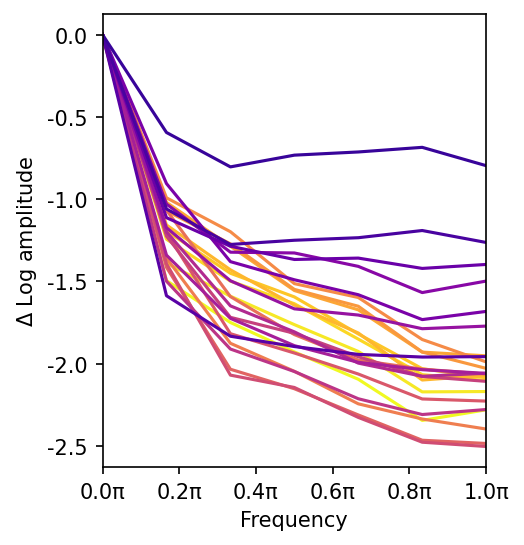

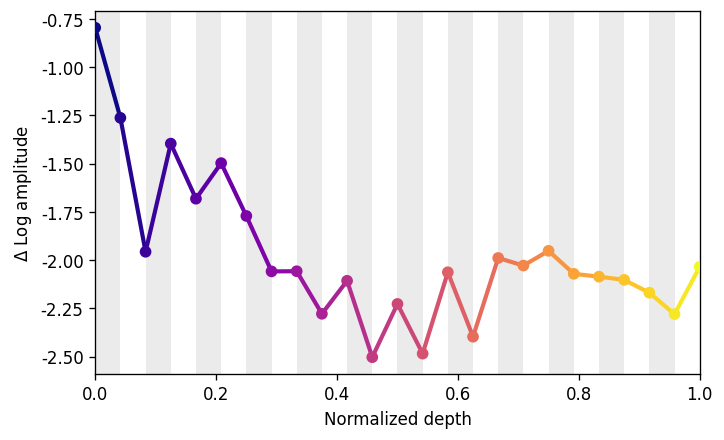

In [5]:
import math

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


def fourier(x):  # 2D Fourier transform
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f


def shift(x):  # shift Fourier transformed feature map
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))


def make_segments(x, y):  # make segment for `plot_segment`
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plot_segment(ax, xs, ys, cmap_name="plasma"):  # plot with cmap segments
    z = np.linspace(0.0, 1.0, len(ys))
    z = np.asarray(z)
    
    cmap = cm.get_cmap(cmap_name)
    norm = plt.Normalize(0.0, 1.0)
    segments = make_segments(xs, ys)
    lc = LineCollection(segments, array=z, cmap=cmap_name, norm=norm,
                        linewidth=2.5, alpha=1.0)
    ax.add_collection(lc)

    colors = [cmap(x) for x in xs]
    ax.scatter(xs, ys, color=colors, marker=marker, zorder=100)
    

# Fourier transform feature maps
fourier_latents = []
for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
    latent = latent.cpu()
    
    if len(latent.shape) == 3:  # for ViT
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
    elif len(latent.shape) == 4:  # for CNN
        b, c, h, w = latent.shape
    else:
        raise Exception("shape: %s" % str(latent.shape))
    latent = fourier(latent)
    latent = shift(latent).mean(dim=(0, 1))
    latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
    latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                 # (i.e., low-freq amp - high freq amp)
    fourier_latents.append(latent)
    

# A. Plot Fig 2a: "Relative log amplitudes of Fourier transformed feature maps"
fig, ax1 = plt.subplots(1, 1, figsize=(3.3, 4), dpi=150)
for i, latent in enumerate(reversed(fourier_latents[:-1])):
    freq = np.linspace(0, 1, len(latent))
    ax1.plot(freq, latent, color=cm.plasma_r(i / len(fourier_latents)))
    
ax1.set_xlim(left=0, right=1)

ax1.set_xlabel("Frequency")
ax1.set_ylabel("$\Delta$ Log amplitude")

from matplotlib.ticker import FormatStrFormatter
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1fπ'))


# B. Plot Fig 8: "Relative log amplitudes of high-frequency feature maps"
if name == "resnet50":  # for ResNet-50
    pools = [4, 8, 14]
    msas = []
    marker = "D"
elif name == "vit_tiny_patch16_224":  # for ViT-Ti
    pools = []
    msas = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,]
    marker = "o"
else:
    import warnings
    warnings.warn("The configuration for %s are not implemented." % name, Warning)
    pools, msas = [], []
    marker = "s"

depths = range(len(fourier_latents))

# Normalize
depth = len(depths) - 1
depths = (np.array(depths)) / depth
pools = (np.array(pools)) / depth
msas = (np.array(msas)) / depth

fig, ax2 = plt.subplots(1, 1, figsize=(6.5, 4), dpi=120)
plot_segment(ax2, depths, [latent[-1] for latent in fourier_latents])  # high-frequency component

for pool in pools:
    ax2.axvspan(pool - 1.0 / depth, pool + 0.0 / depth, color="tab:blue", alpha=0.15, lw=0)
for msa in msas:
    ax2.axvspan(msa - 1.0 / depth, msa + 0.0 / depth, color="tab:gray", alpha=0.15, lw=0)
    
ax2.set_xlabel("Normalized depth")
ax2.set_ylabel("$\Delta$ Log amplitude")
ax2.set_xlim(0.0, 1.0)

from matplotlib.ticker import FormatStrFormatter
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()